# Trimodal integration

In this notebook we demonstrate how to build a trimodal reference atlas and map unimodal as well as multimodal query data onto the reference. We use publically available dataset from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/. We use the preprocessed data (see preprocessing notebooks).

In [1]:
import numpy as np
import scanpy as sc
import multigrate as mtg
import anndata as ad

Global seed set to 0


## Load data

In [2]:
rna_multiome = sc.read('data/trimodal/rna_multiome_hvg.h5ad')
rna_multiome

AnnData object with n_obs × n_vars = 69249 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
rna_cite = sc.read('data/trimodal/rna_cite_hvg.h5ad')
rna_cite

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [4]:
atac = sc.read('data/trimodal/atac_hvf.h5ad')
atac

AnnData object with n_obs × n_vars = 69249 × 20000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'log-norm', 'tf-idf'

In [5]:
adt = sc.read('data/trimodal/adt.h5ad')
adt

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'l1_cell_type', 'l2_cell_type'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'clr', 'counts'

We subset to the reference and query batches.

In [6]:
cite_reference_batches = ['s1d1', 's1d2', 's1d3']
multiome_reference_batches = ['s1d1', 's1d2', 's1d3']
cite_query_batches = ['s2d1', 's2d4']
multiome_query_batches = ['s2d1', 's2d4']

In [7]:
# query
rna_multiome_query = rna_multiome[rna_multiome.obs['batch'].isin(multiome_query_batches)].copy()
atac_query = atac[atac.obs['batch'].isin(multiome_query_batches)].copy()
rna_cite_query = rna_cite[rna_cite.obs['batch'].isin(cite_query_batches)].copy()
adt_query = adt[adt.obs['batch'].isin(cite_query_batches)].copy()
# reference
rna_multiome = rna_multiome[rna_multiome.obs['batch'].isin(multiome_reference_batches)].copy()
atac = atac[atac.obs['batch'].isin(multiome_reference_batches)].copy()
rna_cite = rna_cite[rna_cite.obs['batch'].isin(cite_reference_batches)].copy()
adt = adt[adt.obs['batch'].isin(cite_reference_batches)].copy()

## Prep the input AnnData object

Next, we concatenate all the data into one AnnData object specifying how the data is paired and which layers to use.

In [8]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna_cite, rna_multiome], [None, atac], [adt, None]],
    layers = [['counts', 'counts'], [None, 'log-norm'], [None, None]],
)
adata

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 33554 × 24134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'

Next, we register covariates that the model will correct for in the latent space.

In [9]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    categorical_covariate_keys=['Modality', 'Samplename'],
    rna_indices_end=4000  
)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.X                                                                                   
INFO     Successfully registered anndata object containing 33554 cells, 24134 vars, 1 batches, 1 labels, and 0     
         proteins. Also registered 2 extra categorical covariates and 1 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


## Initialize the model

We specify `integrate_on = 'Modality'` to make sure that joint distributions for CITE-seq and multiome data are well aligned. We also need to specify `mmd = 'marginal'` parameter to allow for unimodal reference mapping later. This ensures that not only joint distributions are aligned but also unimodal marginal distributions. 

The `'integ'` coefficient in `loss_coefs` usually requires some fine-tuning and is dependent on the dataset.

If using raw counts for RNA-seq, specify NB loss, if normalized counts, use MSE loss. For ATAC and ADT, we use normalized counts and MSE loss.

In [10]:
model = mtg.model.MultiVAE(
    adata, 
    losses=['nb', 'mse', 'mse'],
    loss_coefs={'kl': 1e-3,
               'integ': 4000,
               },
    integrate_on='Modality',
    mmd='marginal',
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


## Train the model

One can specify the number of epochs by setting `max_epochs` parameter, default is 256. The default batch size is set to `batch_size = 256`, adjust if needed.

In [11]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 109/200:  55%|█████▍    | 109/200 [16:14<13:33,  8.94s/it, loss=1.95e+03, v_num=1]


## Inference

Get the latent representation and save in explicitely in `.obsm['latent_ref']` as we will overwrite `.obsm['latent']` later when we work with fine-tuned model after query mapping.

In [12]:
model.get_latent_representation()
adata.obsm['latent_ref'] = adata.obsm['latent'].copy()
adata

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


AnnData object with n_obs × n_vars = 33554 × 24134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'modality'
    uns: 'modality_lengths', '_scvi'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent', 'latent_ref'
    layers: 'counts'

Visualize results.

In [13]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 

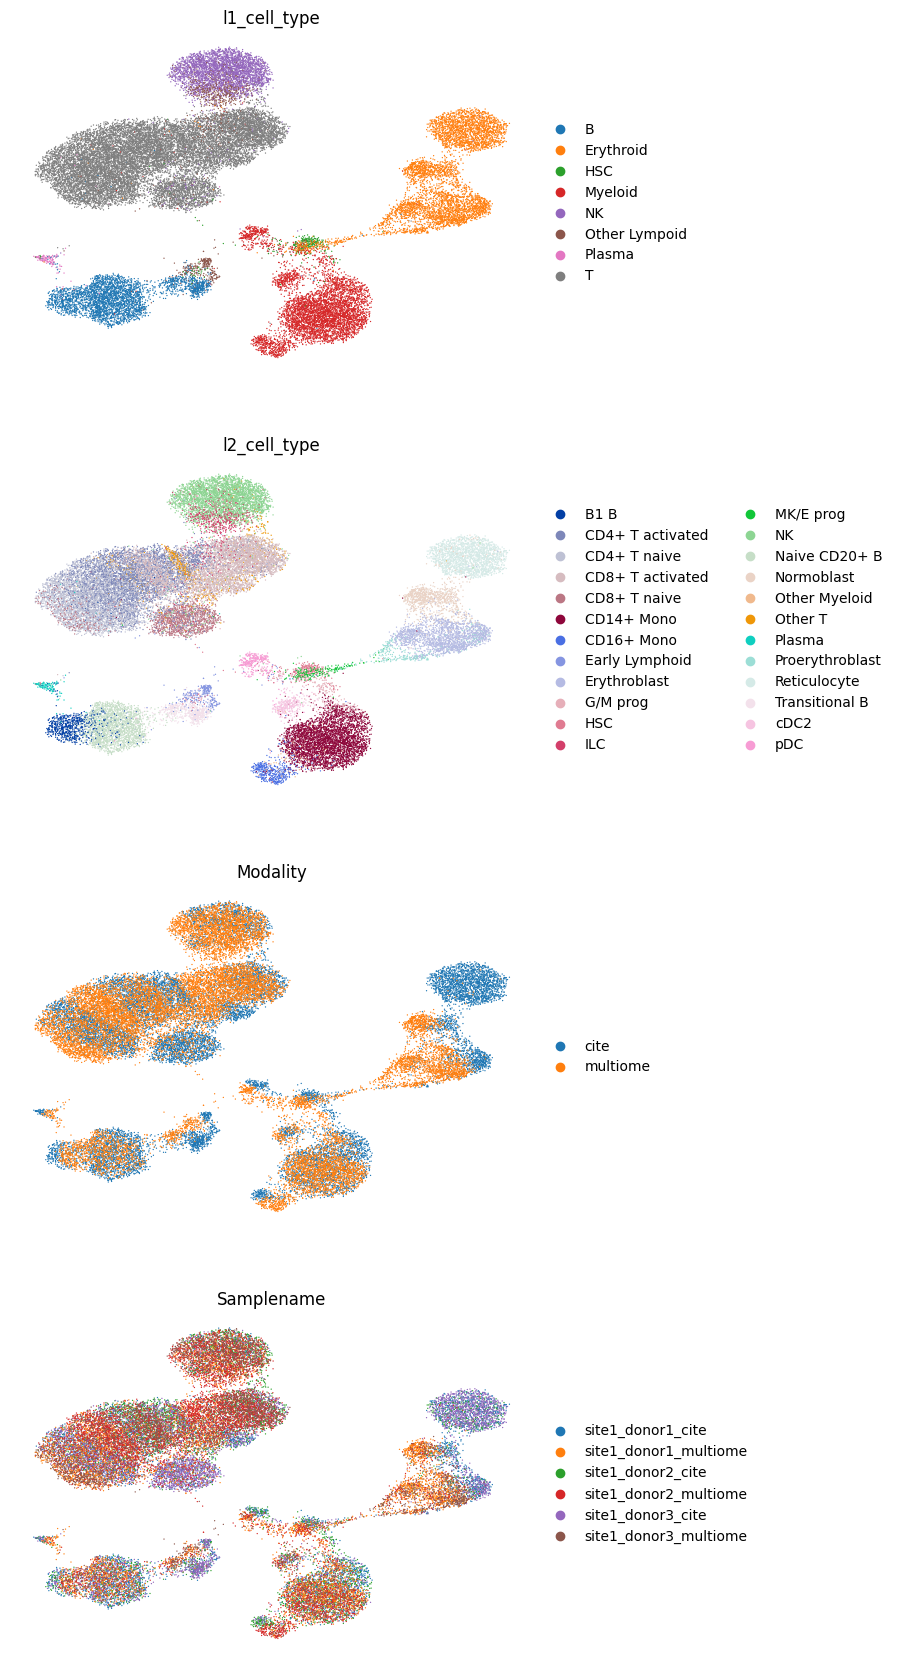

In [14]:
sc.pl.umap(adata, color=['l1_cell_type', 'l2_cell_type', 'Modality', 'Samplename'], ncols=1, frameon=False)

## Query mapping

We repeat the same steps for the setting up the query as for the reference before.

In [15]:
query = mtg.data.organize_multiome_anndatas(
    adatas = [[rna_cite_query, rna_multiome_query], [None, atac_query], [adt_query, None]],
    layers = [['counts', 'counts'], [None, 'log-norm'], [None, None]],
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
mtg.model.MultiVAE.setup_anndata(
    query,
    categorical_covariate_keys=['Modality', 'Samplename'],
    rna_indices_end=4000,
)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.X                                                                                   
INFO     Successfully registered anndata object containing 26380 cells, 24134 vars, 1 batches, 1 labels, and 0     
         proteins. Also registered 2 extra categorical covariates and 1 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


Let's imitate unimodal queries by masking with zeros the snRNA part of one multiome batch and ADT part of one CITE-seq batch in the query. We get one ATAC-only query batch and one scRNA-only query batch respectively.

In [17]:
idx_atac_query = query.obs['Samplename'] == 'site2_donor4_multiome'
idx_scrna_query = query.obs['Samplename'] == 'site2_donor1_cite'

idx_mutiome_query = query.obs['Samplename'] == 'site2_donor1_multiome'
idx_cite_query = query.obs['Samplename'] == 'site2_donor4_cite'

np.sum(idx_atac_query), np.sum(idx_scrna_query), np.sum(idx_mutiome_query), np.sum(idx_cite_query)

(6111, 10465, 4220, 5584)

In [18]:
query[idx_atac_query, :4000].X = 0
query[idx_scrna_query, 4000:].X = 0

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


We update the model by adding new weights to the new batches in the query and fine-tune those weights.

In [19]:
q_model = mtg.model.MultiVAE.load_query_data(query, model)

INFO     Using data from adata.X                                                                                   


/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']                                 
INFO     Successfully registered anndata object containing 26380 cells, 24134 vars, 1 batches, 1 labels, and 0     
         proteins. Also registered 2 extra categorical covariates and 1 extra continuous covariates.               


/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [20]:
q_model.train(weight_decay=0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 105/200:  52%|█████▎    | 105/200 [10:37<09:36,  6.07s/it, loss=1.54e+03, v_num=1]


We obtain the latent representation for the query and the reference from the updated model. Note that the representation of the reference is the same as before up to sampling noise.

In [21]:
q_model.get_latent_representation(batch_size=256, adata=query)
q_model.get_latent_representation(batch_size=256, adata=adata)

INFO     Using data from adata.X                                                                                   


/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scvi/data/_anndata.py:1234: UserWarning: Categorical encoding for Samplename is similar but not equal between the anndata used to train and the anndata passed in. Will attempt transfer. Expected categories: ['site1_donor1_cite' 'site1_donor1_multiome' 'site1_donor2_cite'
 'site1_donor2_multiome' 'site1_donor3_cite' 'site1_donor3_multiome'
 'site2_donor1_cite' 'site2_donor1_multiome' 'site2_donor4_cite'
 'site2_donor4_multiome']. Received categories: ['site1_donor1_cite' 'site1_donor1_multiome' 'site1_donor2_cite'
 'site1_donor2_multiome' 'site1_donor3_cite' 'site1_donor3_multiome'].
 
  warnings.warn(warning_msg.format(cat

INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']                                 
INFO     Successfully registered anndata object containing 33554 cells, 24134 vars, 1 batches, 1 labels, and 0     
         proteins. Also registered 2 extra categorical covariates and 1 extra continuous covariates.               


Finally, we concatentae the reference and the query, and visualize both on a UMAP.

In [22]:
adata.obs['reference'] = 'reference'
query.obs['reference'] = 'query'

adata.obs['type_of_query'] = 'reference'
query.obs.loc[idx_atac_query, 'type_of_query'] = 'ATAC query'
query.obs.loc[idx_scrna_query, 'type_of_query'] = 'scRNA query'
query.obs.loc[idx_mutiome_query, 'type_of_query'] = 'multiome query'
query.obs.loc[idx_cite_query, 'type_of_query'] = 'CITE-seq query'

In [23]:
adata_both = ad.concat([adata, query])

In [24]:
sc.pp.neighbors(adata_both, use_rep='latent')
sc.tl.umap(adata_both)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 

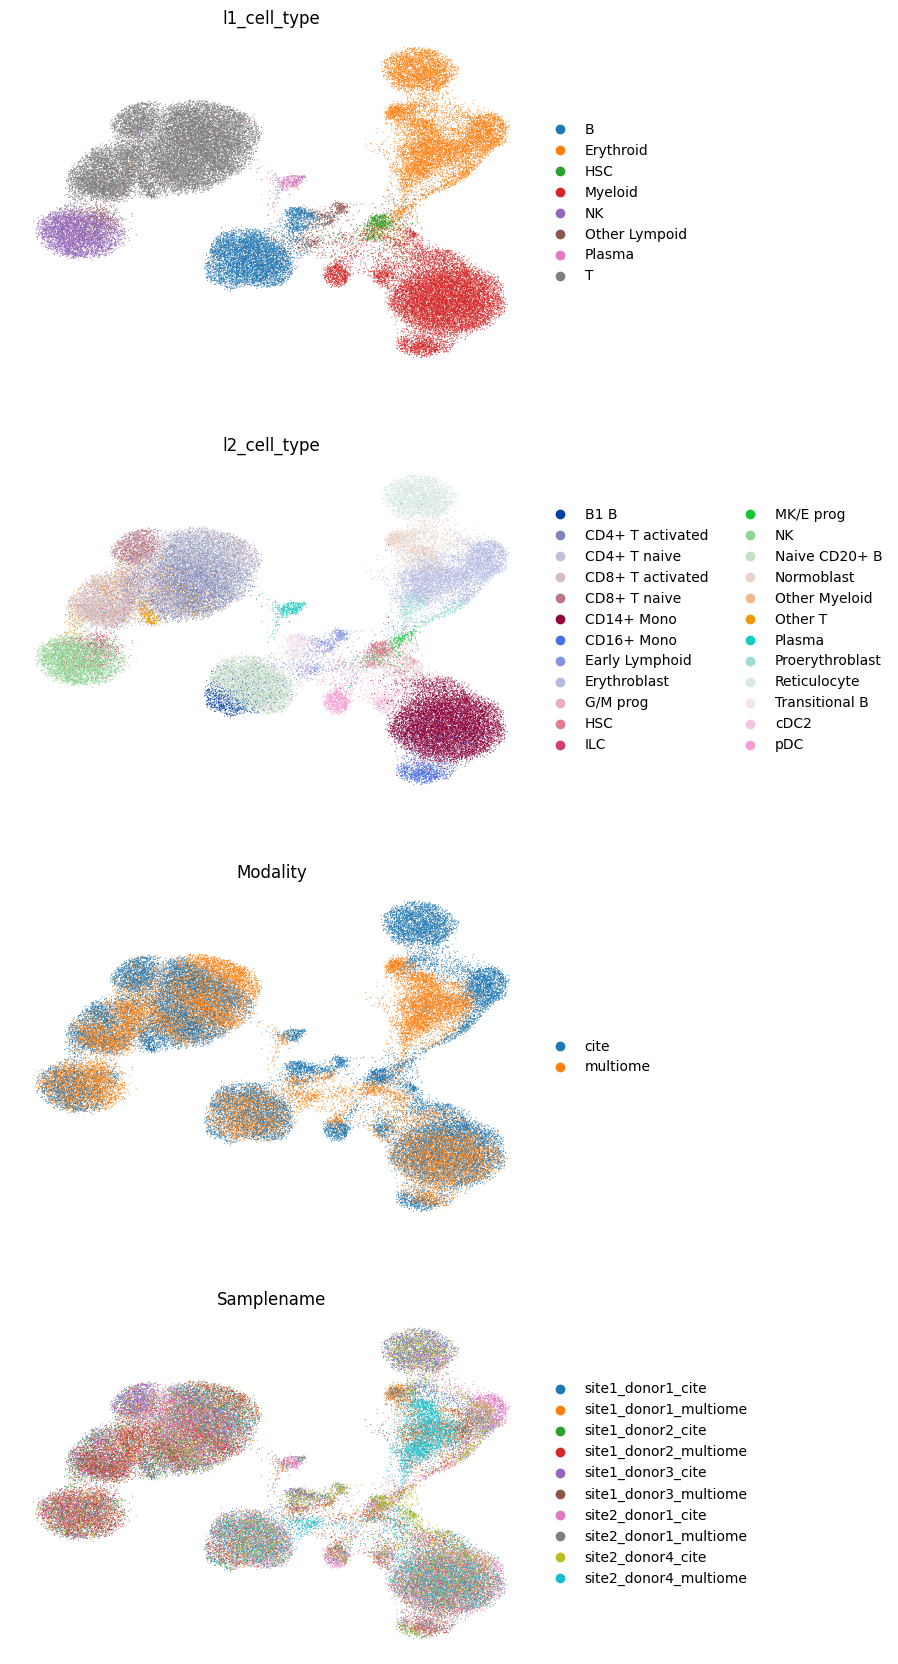

In [25]:
sc.pl.umap(adata_both, color=['l1_cell_type', 'l2_cell_type', 'Modality', 'Samplename'], ncols=1, frameon=False)

We also can take a look at separate multimodal and unimodal queries.

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


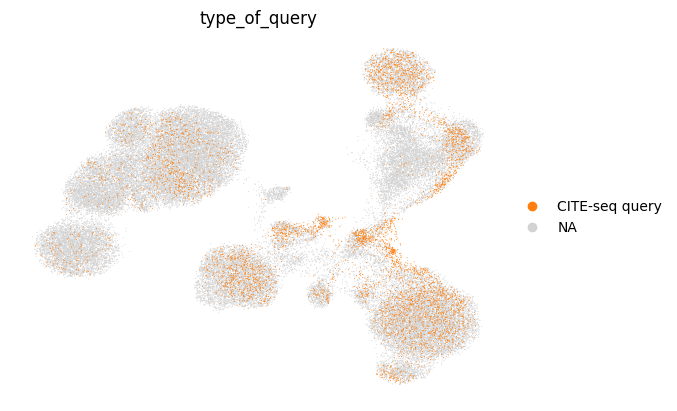

In [26]:
sc.pl.umap(
    adata_both,
    color='type_of_query', 
    ncols=1,
    frameon=False,
    groups=['CITE-seq query']
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


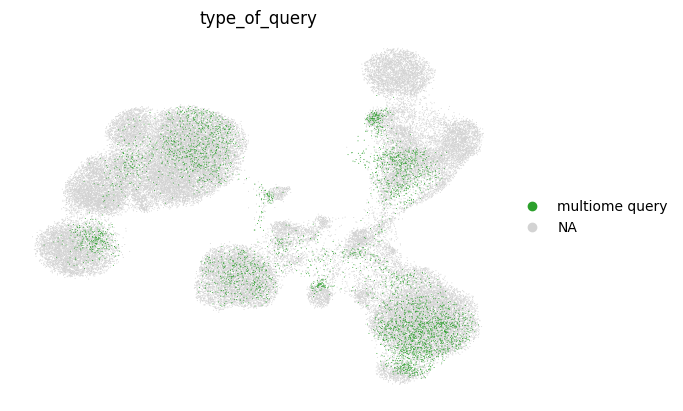

In [27]:
sc.pl.umap(
    adata_both,
    color='type_of_query', 
    ncols=1,
    frameon=False,
    groups=['multiome query']
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


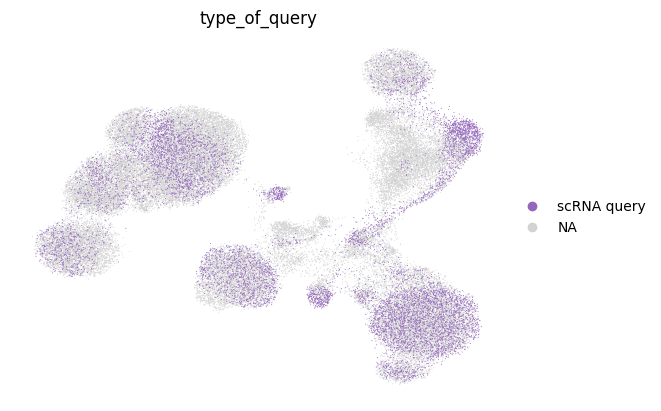

In [28]:
sc.pl.umap(
    adata_both,
    color='type_of_query', 
    ncols=1,
    frameon=False,
    groups=['scRNA query']
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


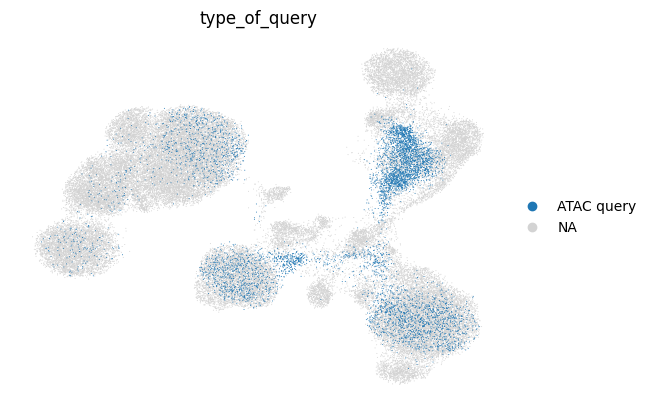

In [29]:
sc.pl.umap(
    adata_both,
    color='type_of_query', 
    ncols=1,
    frameon=False,
    groups=['ATAC query']
)